*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170731_CythonAndComplexNumbers.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170731_CythonAndComplexNumbers.ipynb).*

Last week, I had the pleasure to dive deep into the Cython world in order to solve a physics problem involving complex numbers.
This post describes some of the things I've learnt concerning Cython, complex numbers and parallelization.

# What problem am I trying to solve? 

The problem I was trying to solve was the following: given a vector of complex numbers ($w_i$, "weights"), I wanted to compute it's inverse Fourier transform given a certain angular frequency, $\omega$.

So what I want to compute is this: 

$$
\mathcal{Re}\sum_{i=1}^n w_i \exp(i \omega t)
$$

Beware that $t$ is actually a vector.

# Reference implementation with NumPy 

First, let's see our reference implementation. We make use of NumPy broadcasting to effectively perform the summation part in a single operation over all time steps.

In [1]:
import numpy as np

In [2]:
def synthesis(weights, omega, time_vector):
    """Sums weighted complex exponentials."""
    return (weights[:, np.newaxis] * np.exp(1j * omega * time_vector[np.newaxis, :])).sum(axis=0).real

Let's apply this on some sample data.

In [3]:
weights = (np.random.randn(1000) + 1j * np.random.randn(1000)) * np.exp(-np.arange(1000))
omega = 2 * np.pi * 1e-3
time_vector = np.arange(2000, dtype=np.float)

In [4]:
ref_result = synthesis(weights, omega, time_vector)

Let's inspect the shape and the dtype of the result :

In [5]:
ref_result.shape

(2000,)

In [6]:
ref_result.dtype

dtype('float64')

This is the expected shape since time step vector is of size 2000. Also, our output is floats, meaning the dtype is as expected. Let's plot the result to have some fun.

In [7]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

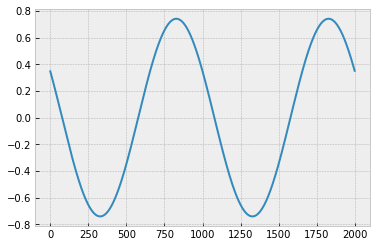

In [8]:
plt.plot(time_vector, ref_result)

Let's move on and port this synthesis function to Cython. We will then time the execution speed and see if Cython allows us to make this function faster.

But first, let's make a detour. To port our function to Cython, we need to be able to do two things:

- use complex number types in Cython
- use the complex exponential "from the C/C++ world"

# Prerequesites for Cython & complex numbers 

## Declaring complex numbers in Cython

So how do you declare a complex number in Cython? Luckily, the Cython tutorial from Scipy 2017 by Kurt Smith comes to the rescue (specifically, [this notebook](https://github.com/kwmsmith/scipy-2017-cython-tutorial/blob/master/03-cython-types.ipynb), but check out [the whole tutorial](https://github.com/kwmsmith/scipy-2017-cython-tutorial), it's a great learning resource).

In [9]:
%load_ext cython

In [10]:
%%cython -a

# `double complex` is preferred for compatibility with Python's `complex` type:
# https://docs.python.org/3/c-api/complex.html

cdef:
    float complex fc = 1+1j
    double complex dc = 1+1j
    long double complex ldc = 1+1j

print(fc, dc, ldc)
print(fc.real, dc.imag, ldc.conjugate())

(1+1j) (1+1j) (1+1j)
1.0 1.0 (1-1j)


Okay, but what about complex numbers in a NumPy array? Well, we can use the memoryview syntax for this.

In [11]:
%%cython -a

def identity(complex [::1] weights):
    return weights

In [12]:
np.allclose(weights, identity(weights))

True

But we can also use the ndarray syntax:

In [13]:
%%cython -a
cimport numpy as np

def identity(np.ndarray [np.complex128_t, ndim=1] weights):
    return weights

In [14]:
np.allclose(weights, identity(weights))

True

We will stick to the above syntax (*np.ndarray*) in what follows.

## The complex exponential

Another thing we need is to have access to the complex exponential in the Cython code. A naive approach is to use the NumPy exponetial: 

In [15]:
%%cython -a
cimport numpy as np
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def apply_complex_exp(np.ndarray [np.complex128_t, ndim=1] weights, np.ndarray [np.complex128_t, ndim=1] out):
    cdef int i
    for i in range(weights.shape[0]):
        out[i] = np.exp(1j * weights[i])

In [16]:
out = np.empty_like(weights)

In [17]:
out.dtype

dtype('complex128')

In [18]:
apply_complex_exp(weights, out)

Let's check the result:

In [19]:
np.allclose(np.exp(1j * weights), out)

True

However, the problem is that we don't get pure C speed on this operation due to the call to a numpy function. There must be a better way. Searching the internet, I found [this StackOverflow thread](https://stackoverflow.com/questions/27906862/complex-valued-calculations-using-cython), which suggests to do the following.

In [20]:
%%cython -a --cplus
cimport numpy as np
import numpy as np
import cython

cdef extern from "complex.h":
    double complex exp(double complex)

@cython.boundscheck(False)
@cython.wraparound(False)
def apply_complex_exp2(np.ndarray [np.complex128_t, ndim=1] weights, np.ndarray [np.complex128_t, ndim=1] out):
    cdef int i
    for i in range(weights.shape[0]):
        out[i] = exp(1j * weights[i])

This allows us translating to pure C... wait-for-it... ++! If you look closely at the above code cell, I had to add the `--cplus` flag to the compiler since the extern definition we are referring to is the built-in header for the a file that on my computer can be found in `Anaconda\Lib\site-packages\Cython\Includes\libcpp`! If I don't add this, I get an error from the compiler...

Let's check that this returns the right result.

In [21]:
apply_complex_exp2(weights, out)

In [22]:
np.allclose(np.exp(1j * weights), out)

True

Let's also check that this is faster:

In [23]:
%timeit apply_complex_exp(weights, out)

1.24 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%timeit apply_complex_exp2(weights, out)

40.8 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Indeed, the second approach that uses C++ is much faster!

With these things in mind, let's now write the Cython version of our reference implementation.

# Cython optimization of the synthesis function 

In [25]:
%%cython -a --cplus
cimport numpy as np
import numpy as np
import cython

cdef extern from "<complex.h>" namespace "std" nogil:
    double complex exp(double complex z)
    double real(double complex z)

cdef double complex I = 1j    
    
@cython.boundscheck(False)
@cython.wraparound(False)
def synthesis_cython1(np.ndarray [np.complex128_t, ndim=1] weights,
                     double omega,
                     np.ndarray [np.float64_t, ndim=1] time_vector):
    cdef int i, j
    cdef np.ndarray [np.float64_t, ndim=1] out = np.empty_like(time_vector, dtype=np.float)
    cdef double complex temp_sum  
    for i in range(time_vector.shape[0]):
        temp_sum = 0
        for j in range(weights.shape[0]):
            temp_sum += weights[j] * exp(I * time_vector[i] * omega )
        out[i] = real(temp_sum)
    return out

In [26]:
out = synthesis_cython1(weights, omega, time_vector)

In [27]:
np.allclose(ref_result, out)

True

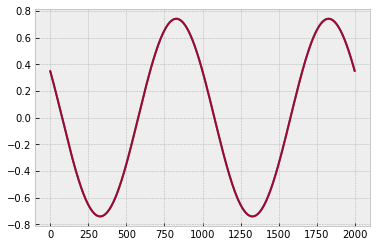

In [28]:
plt.plot(ref_result)
plt.plot(out)

Let's now do some timings.

In [29]:
%timeit synthesis(weights, omega, time_vector)

30.1 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%timeit synthesis_cython1(weights, omega, time_vector)

127 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see, our Cython version is almost ten times slower than our vectorized implementation. Let's try tweaking it.

In [31]:
%%cython -a --cplus
cimport numpy as np
import numpy as np
import cython

cdef extern from "<complex.h>" namespace "std" nogil:
    double complex exp(double complex z)
    double real(double complex z)

cdef double complex I = 1j    
    
@cython.boundscheck(False)
@cython.wraparound(False)
def synthesis_cython2(np.ndarray [np.complex128_t, ndim=1] weights,
                     double omega,
                     np.ndarray [np.float64_t, ndim=1] time_vector):
    cdef int i, j
    cdef np.ndarray [np.float64_t, ndim=1] out = np.empty_like(time_vector, dtype=np.float)
    cdef double complex temp_sum
    cdef double complex temp_mult
    for i in range(time_vector.shape[0]):
        temp_sum = 0
        temp_mult = exp(I * time_vector[i] * omega)
        for j in range(weights.shape[0]):
            temp_sum += weights[j] * temp_mult
        out[i] = real(temp_sum)
    return out

Let's check it's correct again:

In [32]:
out = synthesis_cython2(weights, omega, time_vector)

In [33]:
np.allclose(ref_result, out)

True

In [34]:
%timeit synthesis(weights, omega, time_vector)

29.7 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%timeit synthesis_cython2(weights, omega, time_vector)

27.6 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Nice! Moving the computation of the complex exponent outside of the loop helped us match NumPy. As you can see above however, line 22 is still yellow, meaning there is some Python interaction going on. Can we eliminate that?

In [36]:
%%cython -a --cplus
cimport numpy as np
import numpy as np
import cython

cdef extern from "<complex.h>" namespace "std" nogil:
    double complex exp(double complex z)
    double real(double complex z)

cdef double complex I = 1j    
    
@cython.boundscheck(False)
@cython.wraparound(False)
def synthesis_cython3(np.ndarray [complex, ndim=1] weights,
                     double omega,
                     np.ndarray [double, ndim=1] time_vector):
    cdef int i, j
    cdef np.ndarray [np.float64_t, ndim=1] out = np.empty_like(time_vector, dtype=np.float)
    cdef double complex temp_sum
    cdef double complex temp_mult
    for i in range(time_vector.shape[0]):
        temp_sum = 0
        temp_mult = exp(I * time_vector[i] * omega)
        for j in range(weights.shape[0]):
            temp_sum += weights[j] * temp_mult
        out[i] = real(temp_sum)
    return out

Yes we can! All we did was changing the dtype of the input array. Let's check our function produces correct results again:

In [37]:
out = synthesis_cython3(weights, omega, time_vector)

In [38]:
np.allclose(ref_result, out)

True

In [39]:
%timeit synthesis(weights, omega, time_vector)

29.9 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit synthesis_cython3(weights, omega, time_vector)

28.1 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Interestingly, even though our function is now "completely white", meaning that Cython has translated it to pure C++, it is not actually faster than our previous version. The last thing we can do in our quest for performance is to make the loop parallel.

In [41]:
%%cython -a --cplus --compile-args=/openmp
cimport numpy as np
import numpy as np
import cython
from cython.parallel import prange

cdef extern from "<complex.h>" namespace "std" nogil:
    double complex exp(double complex z)
    double real(double complex z)

cdef double complex I = 1j    
    
@cython.boundscheck(False)
@cython.wraparound(False)
def synthesis_cython4(np.ndarray [complex, ndim=1] weights,
                     double omega,
                     np.ndarray [double, ndim=1] time_vector):
    cdef int i, j
    cdef np.ndarray [np.float64_t, ndim=1] out = np.empty_like(time_vector, dtype=np.float)
    cdef double complex temp_sum
    cdef double complex temp_mult
    for i in prange(time_vector.shape[0], nogil=True):
        temp_sum = 0
        temp_mult = exp(I * time_vector[i] * omega)
        for j in range(weights.shape[0]):
            temp_sum = temp_sum + weights[j] * temp_mult
        out[i] = real(temp_sum)
    return out

Note that I had to give up my `+=` term to compile this since I ran into this error message "Cannot read reduction variable in loop body" (fix found [here](https://stackoverflow.com/questions/40451203/cython-parallel-loop-problems)).

Also, note that I supplied the compiler with the *--/openmp* flag, which is valid under Windows only (for Linux it's *--fopenmp*).

In [42]:
out = synthesis_cython4(weights, omega, time_vector)

In [43]:
np.allclose(ref_result, out)

True

In [44]:
%timeit synthesis(weights, omega, time_vector)

29.1 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%timeit synthesis_cython4(weights, omega, time_vector)

9.23 ms ± 521 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We achieve a nice little speedup to parallel execution on four cores.

# Timings 

Let's time the different versions of our functions!

In [46]:
timings = {}
for func, label in zip([synthesis, synthesis_cython1, synthesis_cython2, synthesis_cython3, synthesis_cython4],
                       ['reference', 'cython1-naive', 'cython2-clever', 'cython3-clever-pure-c++-loop', 'cython-parallel']):
    obj = %timeit -o func(weights, omega, time_vector)
    timings[label] = obj

29.3 ms ± 639 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
123 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.5 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.3 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.76 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
import pandas as pd
s = pd.Series({key: timings[key].average * 1e3 for key in timings}).to_frame(name='timings (ms)').sort_values(by='timings (ms)')
s

,timings (ms)
cython-parallel,8.757900
cython3-clever-pure-c++-loop,27.341302
cython2-clever,27.519439
reference,29.275485
cython1-naive,123.381547


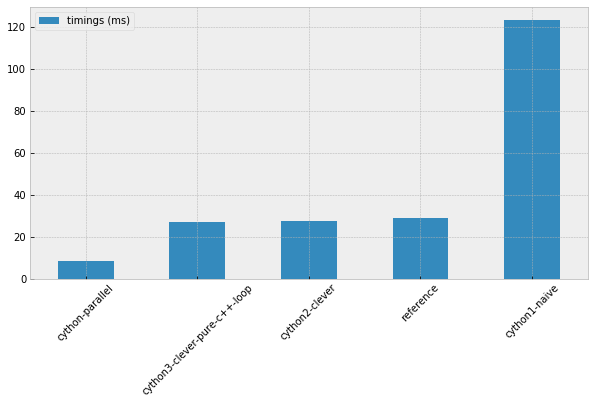

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
s.plot(kind='bar', ax=ax, rot=45)
plt.legend(loc='upper left')

# Conclusions 

So here's the list of the things I learnt while doing this work:

- declaring complex variables within Cython functions
- using C++ std lib functions using cdef extern in Cython code
- Cython allows one to easily parallelize code
- the Cython error messages are often cryptic
- it is useful to read the generated Cython code to understand what's going on under the hood of the translation